In [73]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
import random
from sklearn.preprocessing import scale
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

df = pd.read_csv('training_cleaned.csv')

df["Sentiment"] = df["Sentiment"].map({4:1,0:0})

df.head()
SEED = random.seed(100)
random.seed(100)

In [74]:
df_new = df.loc[df['Tweet'].apply(type) == str].copy()

In [75]:
x = df_new.Tweet
y = df_new.Sentiment

# Create Train, Test and Validate Data Sets (80,10,10)

In [76]:
#Create Train,Validate and TEST Sets (80,10,10)
from sklearn.model_selection import train_test_split

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,classification_report
from sklearn.metrics import classification_report, confusion_matrix
from time import time

# BOW Features

### With N Grams (1 to 3 words)

Create Bag of Words Features for each tweet, will create Features for Unigram, Bigrams and Trigrams

In [78]:
from sklearn.model_selection import GridSearchCV
cvec = CountVectorizer()
lr = LogisticRegression(solver='liblinear')
n_features = np.arange(10000,100001,10000)
vectorizer=cvec
checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', lr)
        ])  

Implement GridSearchCV to find optimal Features using Logistic regression.

Features to optimize are N Grams for 1 to 3 words and number of Features from 10000 to 10000

In [79]:
# Optimize hyperparameters
hyperparameters = { 
                    'vectorizer__ngram_range': [(1,1), (1,2),(1,3)],
                   'vectorizer__max_features': n_features,
        
                    
                  }
clf = GridSearchCV(checker_pipeline, hyperparameters, cv=5,scoring = 'accuracy')
 
# Fit and tune model
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 'vectorizer__max_features': array([ 10000,  20000,  30000,  40000,  50000,  60000,  70000,  80000,
        90000, 100000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Confirm GridSearchCV is finding optimal parameters

Use function plot_grid_search() to plot results from GridSearchCV and see Test accuracy by each parameters

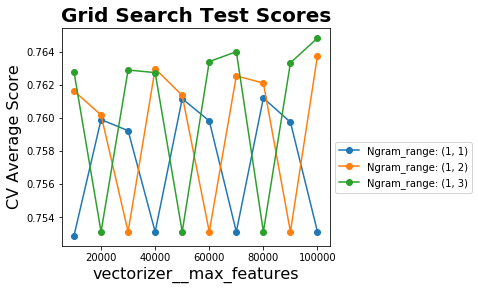

In [80]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    ax.set_title("Grid Search Test Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    #ax.legend(loc="best", fontsize=15)
    #ax.grid('on')

plot_grid_search(clf.cv_results_, n_features, [(1,1), (1,2),(1,3)], 'vectorizer__max_features', 'Ngram_range')

Use plot_test_vs_train() function and best performing N Gram feature to compare
Train vs Test accuracy to see if GridSearchCV is choosing optimal parameters to reduce bias and variance

c:\users\tblakeley\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


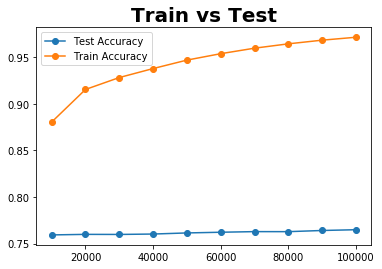

In [82]:
def plot_test_vs_train(cv_results,xaxis_parameter,filter_paramter,filter_value):
    mean_test_results = cv_results["mean_test_score"]

    mean_train_results = cv_results["mean_train_score"]

    parameters = cv_results['params']

    test_vs_train1 = pd.DataFrame(parameters)#,mean_test_results,mean_train_results)
    test_vs_train2= pd.DataFrame({"Test Accuracy":mean_test_results,"Train Accuracy":mean_train_results})
    test_vs_train = pd.concat([test_vs_train1,test_vs_train2],axis=1,sort=False)
    test_vs_train[test_vs_train[filter_paramter]==filter_value][xaxis_parameter]



    plt.plot(test_vs_train[test_vs_train[filter_paramter]==filter_value][xaxis_parameter],
           test_vs_train[test_vs_train[filter_paramter]==filter_value]["Test Accuracy"], '-o', label= "Test Accuracy")
    plt.plot(test_vs_train[test_vs_train[filter_paramter]==filter_value][xaxis_parameter],
           test_vs_train[test_vs_train[filter_paramter]==filter_value]["Train Accuracy"], '-o', label= "Train Accuracy")
    plt.legend(['Test Accuracy', 'Train Accuracy'], loc='upper left')
    plt.title('Train vs Test', fontsize=20, fontweight='bold')
    plt.show()

plot_test_vs_train(clf.cv_results_,"vectorizer__max_features","vectorizer__ngram_range",
                   clf.best_params_['vectorizer__ngram_range'])



Refit the model to use best parameters not the last run parameters using .refit.

Create variables to hold BOW scores to compare to other models run later

In [10]:
clf.refit
preds = clf.predict(x_test)
BOWaccuracy = accuracy_score(y_test, preds)
BOWprecision, BOWrecall, BOWfscore, BOWsupport = precision_recall_fscore_support(y_test,preds)

BOWngram = clf.best_params_['vectorizer__ngram_range']
BOWnfreatures = clf.best_params_['vectorizer__max_features']
print("accuracy score: {0:.2f}%".format(BOWaccuracy*100))

#Find Best Parameters
clf.best_params_

accuracy score: 76.94%


{'vectorizer__max_features': 100000, 'vectorizer__ngram_range': (1, 2)}

# Term Frequency and Inverse Document Frequency (TF_IDF)

### N Grams (1 to 3 words)

Create Term Frequency and Inverse Document Frequency (TF_IDF) Features for each tweet, will create Features for Unigram, Bigrams and Trigrams

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
vectorizer=tfidf
checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', lr)
        ])  

Again Implement GridSearchCV to find optimal Features using Logistic regression.

Features to optimize are N Grams for 1 to 3 words and number of Features from 10000 to 10000

In [12]:
# Optimize hyperparameters
hyperparameters = { 
                    'vectorizer__ngram_range': [(1,1), (1,2),(1,3)],
                   'vectorizer__max_features': n_features,
        
                    
                  }
clf = GridSearchCV(checker_pipeline, hyperparameters, cv=5,scoring = 'accuracy',return_train_score=True)
 
# Fit and tune model
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 'vectorizer__max_features': array([ 10000,  20000,  30000,  40000,  50000,  60000,  70000,  80000,
        90000, 100000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Confirm GridSearchCV is finding optimal parameters

Use function plot_grid_search() to plot results from GridSearchCV and see Test accuracy by each parameters

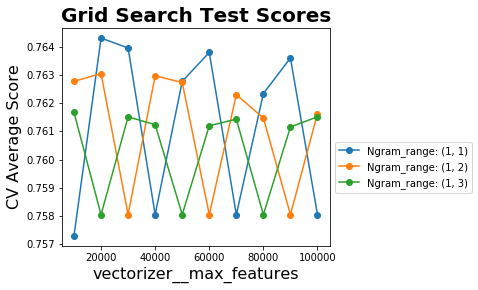

In [13]:
# plot parameters and test accuracy
plot_grid_search(clf.cv_results_, n_features, [(1,1), (1,2),(1,3)], 'vectorizer__max_features', 'Ngram_range')

Use plot_test_vs_train() function and best performing N Gram feature to compare
Train vs Test accuracy to see if GridSearchCV is choosing optimal parameters to reduce bias and variance

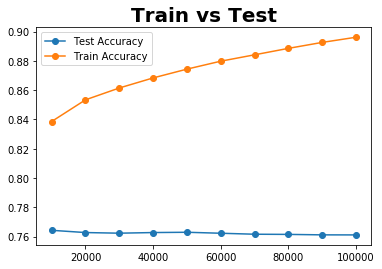

In [14]:
#Look at Train vs Test of top Test accuracy Ngram (1,2)
plot_test_vs_train(clf.cv_results_,"vectorizer__max_features","vectorizer__ngram_range",
                   clf.best_params_['vectorizer__ngram_range'])

In [15]:
#See what the Best Parameters were
clf.best_params_

{'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}

Refit the model to use best parameters not the last run parameters using .refit.

Compare best TD_IDF model to best BOW model

In [16]:
clf.refit
preds = clf.predict(x_test)
TF_IDF_accuracy = accuracy_score(y_test, preds)

TF_IDFprecision, TF_IDFrecall, TF_IDFfscore, TF_IDFsupport = precision_recall_fscore_support(y_test,preds)

TF_IDFngram = clf.best_params_['vectorizer__ngram_range']
TF_IDFnfreatures = clf.best_params_['vectorizer__max_features']


df_Accuracy = pd.DataFrame({
    'Model': ["LogisticRegression","LogisticRegression"],
    'Features': ["Bag of Words", "TF_IDF"],
    'Max Features' : [BOWnfreatures,TF_IDFnfreatures],
    'N Gram' : [BOWngram,TF_IDFngram],
    'Accuracy': [BOWaccuracy,TF_IDF_accuracy],
    'Precision': [BOWprecision[0],TF_IDFprecision[0]],
    'Recall' : [BOWrecall[0],TF_IDFrecall[0]],
    'Fscore': [BOWfscore[0],TF_IDFfscore[0]]
})
df_Accuracy

,Model,Features,Max Features,N Gram,Accuracy,Precision,Recall,Fscore
0,LogisticRegression,Bag of Words,100000,"(1, 2)",0.769424,0.780713,0.746684,0.763319
1,LogisticRegression,TF_IDF,10000,"(1, 2)",0.774143,0.778852,0.763108,0.770900


# Global Vectors for Word Representation (GloVe) Features

We also choose to create features using a pre built word embedding model built using the GloVe algorithm.  GloVe
is a unsupervised algorithm that can be used to get a vector representation of a word.  We used the pre built Glove Twitter 200 
model, this model was trained on tweets and each word is transformed to a vector representation of length 200.

Since each Tweet is made of multiple words, we need some way to represent all the words as one vector, we choose to look at 2 ways of combing word vectors.  The first was to take the mean of all the word vector and the second was to take the sum of all words.  The function get_w2v_general() is used to transform each word and combine each group of words.

In [17]:
import gensim.downloader as api

#function to create one vector for multiple words by taking average vector of words or sum of vectors

def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec
    

c:\users\tblakeley\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [18]:
#Load pre built GLOVE model
glove_twitter = api.load("glove-twitter-200")

Transform each words by using get_w2v_general()

In [19]:
#create single tweet vector by averaging each word vector
vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in df_new["Tweet"]]))
#create single tweet vector by summing each word vector
vecs_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'sum') for z in df_new["Tweet"]]))

Split Data again into Train, Test and Validate samples using the transformed word vectors (80,10,10)

In [20]:
glove_x_train, glove_x_validation_and_test, glove_y_train, glove_y_validation_and_test = train_test_split(vecs_glove_mean, y, test_size=.2, random_state=SEED)
glove_x_validation, glove_x_test, glove_y_validation, glove_y_test = train_test_split(glove_x_validation_and_test, glove_y_validation_and_test, test_size=.5, random_state=SEED)

Implement a simple Logistic Regression model and see how GloVe compares to BOW and TF_IDF models

In [21]:
lr = LogisticRegression(solver='liblinear')

model = lr.fit(glove_x_train,glove_y_train)
preds = model.predict(glove_x_test)
GLOVE_accuracy = accuracy_score(glove_y_test, preds)
GLOVE_precision, GLOVE_Frecall, GLOVE_fscore, GLOVE_support = precision_recall_fscore_support(glove_y_test,preds)

df_glove = pd.DataFrame({"Model":["Logistic Regression"],
                        "Features": ["GLOVE Word Embeddings Mean"],
                        "Accuracy":[GLOVE_accuracy],
                        'Precision': [GLOVE_precision[0]],
                        'Recall' : [GLOVE_Frecall[0]],
                        'Fscore': [GLOVE_fscore[0]]
                        })

df_Final_Accuracy = pd.concat([df_Accuracy,df_glove],sort=False)
df_Final_Accuracy
#print("GLOVE Linear Regression accuracy score: {0:.2f}%".format(GLOVE_accuracy*100))

,Model,Features,Max Features,N Gram,Accuracy,Precision,Recall,Fscore
0,LogisticRegression,Bag of Words,100000.0,"(1, 2)",0.769424,0.780713,0.746684,0.763319
1,LogisticRegression,TF_IDF,10000.0,"(1, 2)",0.774143,0.778852,0.763108,0.770900
0,Logistic Regression,GLOVE Word Embeddings Mean,NaN,NaN,0.734508,0.733248,0.729524,0.731381


In [22]:
sum_glove_x_train, sum_glove_x_validation_and_test, sum_glove_y_train,sum_glove_y_validation_and_test = train_test_split(vecs_glove_sum, y, test_size=.2, random_state=SEED)
sum_glove_x_validation, sum_glove_x_test, sum_glove_y_validation, sum_glove_y_test = train_test_split(sum_glove_x_validation_and_test, sum_glove_y_validation_and_test, test_size=.5, random_state=SEED)

In [23]:
lr = LogisticRegression(solver='liblinear')

model = lr.fit(sum_glove_x_train,sum_glove_y_train)
preds = model.predict(sum_glove_x_test)
GLOVE_accuracy = accuracy_score(sum_glove_y_test, preds)
GLOVE_precision, GLOVE_Frecall, GLOVE_fscore, GLOVE_support = precision_recall_fscore_support(sum_glove_y_test,preds)

df_glove = pd.DataFrame({"Model":["Logistic Regression"],
                        "Features": ["GLOVE Word Embeddings SUM"],
                        "Accuracy":[GLOVE_accuracy],
                        'Precision': [GLOVE_precision[0]],
                        'Recall' : [GLOVE_Frecall[0]],
                        'Fscore': [GLOVE_fscore[0]]
                        })

df_Final_Accuracy = pd.concat([df_Final_Accuracy,df_glove],sort=False)
df_Final_Accuracy
#print("GLOVE Linear Regression accuracy score: {0:.2f}%".format(GLOVE_accuracy*100))

,Model,Features,Max Features,N Gram,Accuracy,Precision,Recall,Fscore
0,LogisticRegression,Bag of Words,100000.0,"(1, 2)",0.769424,0.780713,0.746684,0.763319
1,LogisticRegression,TF_IDF,10000.0,"(1, 2)",0.774143,0.778852,0.763108,0.770900
0,Logistic Regression,GLOVE Word Embeddings Mean,NaN,NaN,0.734508,0.733248,0.729524,0.731381
0,Logistic Regression,GLOVE Word Embeddings SUM,NaN,NaN,0.740170,0.735984,0.728387,0.732166


# Other Models

Now that we seen the results for Linear Regression, we wondered if a more complicated model would do better and use different features.

We choose to Implement a number of different types of basic models

Logistic Regression
Linear Support Vector Classification
K Nearest Neighbours

We also choose to implement 3 different types of ensemble models

AdaBoostClassifier which uses boosting

RandomForestClassifier, which uses bagging

We also wanted to try XGBClassifier as it was the most talked about algorithm and most people recommend using it from reading different kaggle 

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier
names = ["Logistic Regression", "Linear SVC"#,"Multinomial NB", 
          ,"RandomForest", "AdaBoost","KNN","XGBOOST"#,"STACKClassifier"
        ]
classifiers = [
    LogisticRegression(solver='liblinear'),
    LinearSVC(),
    RandomForestClassifier(n_estimators=10),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    XGBClassifier(),
    #StackingClassifier(classifiers=[LogisticRegression(),KNeighborsClassifier()
                                   # ,XGBClassifier()], 
                          #meta_classifier=lr)
    ]
zipped_clf = zip(names,classifiers)




In [25]:
# Loop through features

df_All = pd.DataFrame()

for i in [tfidf,cvec]:
        
    for n,c in zipped_clf:
        loop_pipeline = Pipeline([
                ('vectorizer', i),
                ('classifier', c)
            ])  
        # Optimize hyperparameters
        hyperparameters = {'vectorizer__ngram_range': [(1,2),(1,3)],'vectorizer__max_features': n_features}
        clf = GridSearchCV(loop_pipeline, hyperparameters, cv=5,scoring = 'accuracy',return_train_score=True)

        # Fit and tune model
        #print(clf.estimator)

        t0 = time()
        clf.fit(x_train, y_train)
        clf.refit
        train_test_time = time() - t0
        preds = clf.predict(x_test)
        accuracy = accuracy_score(y_test, preds)
        model_precision, model_recall, model_fscore, model_support = precision_recall_fscore_support(y_test,preds)
        bestngram = clf.best_params_['vectorizer__ngram_range']
        bestnfeatures = clf.best_params_['vectorizer__max_features']
        df_loop = pd.DataFrame([n,i,bestnfeatures,bestngram,accuracy,model_precision[0],model_recall[0],model_fscore[0]])
        df_All = df_All.append(df_loop.T, ignore_index = True)
        print("Model: {0}".format(n))
        print("Features: {0}".format(clf.best_params_))
        print("Accuracy: {0:.2f}%".format(accuracy*100))
        print("train and test time: {0:.2f}s".format(train_test_time))
        print("-"*80)
        df_All

Model: Logistic Regression
Features: {'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
Accuracy: 77.41%
train and test time: 139.39s
--------------------------------------------------------------------------------
Model: Linear SVC
Features: {'vectorizer__max_features': 100000, 'vectorizer__ngram_range': (1, 3)}
Accuracy: 75.81%
train and test time: 129.32s
--------------------------------------------------------------------------------
Model: RandomForest
Features: {'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 3)}
Accuracy: 73.51%
train and test time: 737.81s
--------------------------------------------------------------------------------
Model: AdaBoost
Features: {'vectorizer__max_features': 40000, 'vectorizer__ngram_range': (1, 3)}
Accuracy: 71.66%
train and test time: 292.66s
--------------------------------------------------------------------------------
Model: KNN
Features: {'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1

In [26]:
df_All

,0,1,2,3,4,5,6,7
0,Logistic Regression,"TfidfVectorizer(analyzer='word', binary=False,...",10000,"(1, 2)",0.774143,0.778852,0.763108,0.7709
1,Linear SVC,"TfidfVectorizer(analyzer='word', binary=False,...",100000,"(1, 3)",0.7581,0.746966,0.777637,0.761993
2,RandomForest,"TfidfVectorizer(analyzer='word', binary=False,...",10000,"(1, 3)",0.735137,0.716793,0.773847,0.744228
3,AdaBoost,"TfidfVectorizer(analyzer='word', binary=False,...",40000,"(1, 3)",0.716578,0.755622,0.636766,0.691121
4,KNN,"TfidfVectorizer(analyzer='word', binary=False,...",10000,"(1, 2)",0.582888,0.702362,0.281744,0.402164
5,XGBOOST,"TfidfVectorizer(analyzer='word', binary=False,...",70000,"(1, 3)",0.717207,0.769716,0.616551,0.684672


In [27]:
final_df = df_All[[0,2,3,4,5,6,7]]

In [28]:
final_df.columns = ['Model','Max Features','N Gram','Accuracy','Precision','Recall','Fscore']

In [29]:
final_df

,Model,Max Features,N Gram,Accuracy,Precision,Recall,Fscore
0,Logistic Regression,10000,"(1, 2)",0.774143,0.778852,0.763108,0.7709
1,Linear SVC,100000,"(1, 3)",0.7581,0.746966,0.777637,0.761993
2,RandomForest,10000,"(1, 3)",0.735137,0.716793,0.773847,0.744228
3,AdaBoost,40000,"(1, 3)",0.716578,0.755622,0.636766,0.691121
4,KNN,10000,"(1, 2)",0.582888,0.702362,0.281744,0.402164
5,XGBOOST,70000,"(1, 3)",0.717207,0.769716,0.616551,0.684672


# Models with GloVe Features

In [86]:
df_Final_Accuracy

,Model,Features,Max Features,N Gram,Accuracy,Precision,Recall,Fscore
0,LogisticRegression,Bag of Words,100000.0,"(1, 2)",0.769424,0.780713,0.746684,0.763319
1,LogisticRegression,TF_IDF,10000.0,"(1, 2)",0.774143,0.778852,0.763108,0.770900
0,Logistic Regression,GLOVE Word Embeddings Mean,NaN,NaN,0.734508,0.733248,0.729524,0.731381
0,Logistic Regression,GLOVE Word Embeddings SUM,NaN,NaN,0.740170,0.735984,0.728387,0.732166


In the above chart we can see GloVe features that use the SUM of the words vectors to represent the tweet
has the highest Fscore.  Will now compare different algorithms to the GloVe SUM features.

In [51]:
g_names = ["Logistic Regression", "Linear SVC"#,"Multinomial NB", 
          ,"RandomForest", "AdaBoost","KNN","XGBOOST","STACKClassifier"]
g_classifiers = [
    LogisticRegression(solver='liblinear'),
    LinearSVC(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    XGBClassifier(max_depth=30),
    # Add Stacking Classifier
    StackingClassifier(classifiers=[LogisticRegression(),RandomForestClassifier(n_estimators=200)
                                    ,XGBClassifier(max_depth=30)], 
                          meta_classifier=LogisticRegression(solver='liblinear'))
    ]

glove_zipped_clf = zip(g_names,g_classifiers)

In [52]:
df_All_glove = pd.DataFrame()
for n,c in glove_zipped_clf:
    t0 = time()
    
    # Fit and tune model
    #print(clf.estimator)
  
    clf = c.fit(sum_glove_x_train,sum_glove_y_train)
    train_test_time = time() - t0
    preds = clf.predict(sum_glove_x_test)
    accuracy = accuracy_score(sum_glove_y_test, preds)
    model_precision, model_recall, model_fscore, model_support = precision_recall_fscore_support(sum_glove_y_test,preds)
    #bestngram = clf.best_params_['vectorizer__ngram_range']
    #bestnfeatures = clf.best_params_['vectorizer__max_features']
    df_loop = pd.DataFrame([n,
                            #bestnfeatures,bestngram,
                            accuracy,model_precision[0],model_recall[0],model_fscore[0]])
    df_All_glove = df_All_glove.append(df_loop.T, ignore_index = True)
    print("Model: {0}".format(n))
    #print("Features: {0}".format(clf.best_params_))
    print("Accuracy: {0:.2f}%".format(accuracy*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    df_All_glove

Model: Logistic Regression
Accuracy: 74.02%
train and test time: 2.54s
--------------------------------------------------------------------------------


c:\users\tblakeley\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model: Linear SVC
Accuracy: 73.07%
train and test time: 30.51s
--------------------------------------------------------------------------------
Model: RandomForest
Accuracy: 72.13%
train and test time: 125.40s
--------------------------------------------------------------------------------
Model: AdaBoost
Accuracy: 70.27%
train and test time: 69.15s
--------------------------------------------------------------------------------
Model: KNN
Accuracy: 68.35%
train and test time: 0.69s
--------------------------------------------------------------------------------
Model: XGBOOST
Accuracy: 72.85%
train and test time: 479.80s
--------------------------------------------------------------------------------


c:\users\tblakeley\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: STACKClassifier
Accuracy: 71.53%
train and test time: 617.68s
--------------------------------------------------------------------------------


In [53]:
df_All_glove.columns = ['Model','Accuracy','Precision','Recall','Fscore']
df_All_glove

,Model,Accuracy,Precision,Recall,Fscore
0,Logistic Regression,0.74017,0.735984,0.728387,0.732166
1,Linear SVC,0.730733,0.729194,0.712258,0.720627
2,RandomForest,0.721296,0.699041,0.752258,0.724674
3,AdaBoost,0.702737,0.696047,0.692903,0.694471
4,KNN,0.683548,0.674583,0.678065,0.676319
5,XGBOOST,0.728531,0.715091,0.736774,0.725771
6,STACKClassifier,0.715319,0.673667,0.807097,0.73437


We Implemented the same models we used for the TF-IDf features but we also implmented a StackingClassfier that combines the output of 
Logistic Regression, Random Forest and XgBoost outputs and performs a logistic regression on the outputs.  We can see from the above 
the StackClassifier has the best Fscore, it has a much higher Recall score then any of the other models.

# Hyperparameters Model Tuning

Due to tiime and system contraints we only performed hyperparameters tuning on the GloVe Features with the Random Forest algorithm

In [47]:
param_test_rf = {
 'max_depth': [10, 20, 30],
 'n_estimators': [100,300,500]
}
rf_tune = GridSearchCV(estimator = RandomForestClassifier(), 
 param_grid = param_test_rf, scoring='accuracy',iid=False, cv=3,verbose = 5)

rf_tune.fit(sum_glove_x_train,sum_glove_y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, n_estimators=100, score=0.7024539877300614, total=  33.9s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.6s remaining:    0.0s


[CV]  max_depth=10, n_estimators=100, score=0.7075271354412459, total=  34.8s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  max_depth=10, n_estimators=100, score=0.703834808259587, total=  35.6s
[CV] max_depth=10, n_estimators=300 ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


[CV]  max_depth=10, n_estimators=300, score=0.7135441245870694, total= 1.8min
[CV] max_depth=10, n_estimators=300 ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.6min remaining:    0.0s


[CV]  max_depth=10, n_estimators=300, score=0.7120103822557811, total= 1.8min
[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.7115044247787611, total= 1.8min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.7149598867390279, total= 2.9min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.71295422369042, total= 2.9min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.7153982300884956, total= 2.9min
[CV] max_depth=20, n_estimators=100 ..................................
[CV]  max_depth=20, n_estimators=100, score=0.7017461066540821, total=  45.7s
[CV] max_depth=20, n_estimators=100 ..................................
[CV]  max_depth=20, n_estimators=100, score=0.7048135913166588, total=  45.4s
[CV] max_depth=20, n_estimator

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 55.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'max_depth': [10, 20, 30], 'n_estimators': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

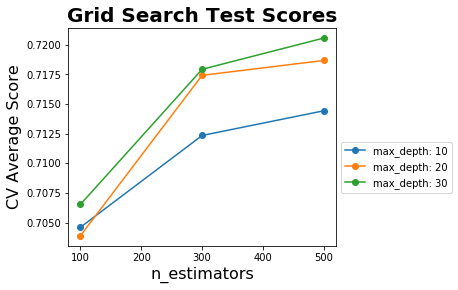

In [63]:
plot_grid_search(rf_tune.cv_results_, [100,300,500], [10, 20, 30], 'n_estimators', 'max_depth')

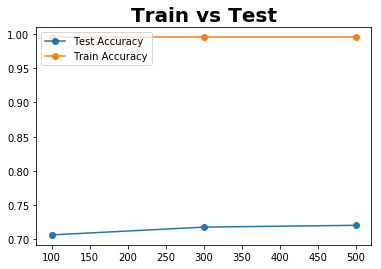

In [83]:
plot_test_vs_train(rf_tune.cv_results_,"n_estimators","max_depth",
                   rf_tune.best_params_['max_depth'])

In [84]:
rf_tune.best_params_

{'max_depth': 30, 'n_estimators': 500}

In [89]:
rf_tune.best_score_

0.7205727224257004

In [102]:
df_All_rf=pd.DataFrame()
preds = rf_tune.predict(sum_glove_x_test)
accuracy = accuracy_score(sum_glove_y_test, preds)
model_precision, model_recall, model_fscore, model_support = precision_recall_fscore_support(sum_glove_y_test,preds)
#bestngram = clf.best_params_['vectorizer__ngram_range']
#bestnfeatures = clf.best_params_['vectorizer__max_features']
df_rf = pd.DataFrame([accuracy,model_precision[0],model_recall[0],model_fscore[0]])
df_All_rf = df_All_rf.append(df_rf.T, ignore_index = True)

In [152]:
df_All_rf.columns = ['Accuracy','Precision','Recall','Fscore']
print("Non Tuned Random Forest")
df_All_rf

Non Tuned Random Forest


,Accuracy,Precision,Recall,Fscore
0,0.722554,0.700721,0.752258,0.725576


In [153]:
print("Tuned Random Forest")
df_All_glove[df_All_glove["Model"]=='RandomForest']

Tuned Random Forest


,Model,Accuracy,Precision,Recall,Fscore
2,RandomForest,0.721296,0.699041,0.752258,0.724674


We can see from the hyperparameters tuning the model was able to slighlty increase the Fscore to 72.56% from 72.47%.  We also observed that the model 
was still seeing increases in test accuracy and little change in training accuracy.  This leads us to believe we can increase the complexity of the model 
more and still get some increase in accuracy.

# Evaluaton with Validation Data Set

Now we want to evualate the our best models for each features with the Validations data set. This data set has not been used in model traing or tuning.  We will re train each model on the train and test data sets and compare the accuracy of the validation data set.

In [112]:
x_train_eval = pd.concat([x_train,x_test],axis=1)
y_train_eval = pd.concat([y_train,y_test],axis=1)
#x_validation y_validation

In [113]:
final_df

,Model,Max Features,N Gram,Accuracy,Precision,Recall,Fscore
0,Logistic Regression,10000,"(1, 2)",0.774143,0.778852,0.763108,0.7709
1,Linear SVC,100000,"(1, 3)",0.7581,0.746966,0.777637,0.761993
2,RandomForest,10000,"(1, 3)",0.735137,0.716793,0.773847,0.744228
3,AdaBoost,40000,"(1, 3)",0.716578,0.755622,0.636766,0.691121
4,KNN,10000,"(1, 2)",0.582888,0.702362,0.281744,0.402164
5,XGBOOST,70000,"(1, 3)",0.717207,0.769716,0.616551,0.684672


The best model for TF-IDF features was the Logistic regression model, we will know re run the linear regression model with the same parameters using the validation datasets

In [122]:
tfidf = TfidfVectorizer(max_features=10000,ngram_range=(1,2))
vectorizer=tfidf
checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', lr)
        ]) 

In [124]:
# Optimize hyperparameters
hyperparameters = { 
                    'vectorizer__ngram_range': [(1,2)],
                   'vectorizer__max_features': [10000],
        
                    
                  }
clf_x = GridSearchCV(checker_pipeline, hyperparameters, cv=5,scoring = 'accuracy',return_train_score=True)
 
# Fit and tune model
clf_x.fit(x_train_eval, y_train_eval)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorizer__ngram_range': [(1, 2)], 'vectorizer__max_features': [10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [131]:
df_lr =pd.DataFrame()
preds = clf_x.predict(x_validation)
accuracy = accuracy_score(y_validation, preds)
model_precision, model_recall, model_fscore, model_support = precision_recall_fscore_support(y_validation,preds)
#bestngram = clf.best_params_['vectorizer__ngram_range']
#bestnfeatures = clf.best_params_['vectorizer__max_features']
df_loop_lr = pd.DataFrame(['Logistic Regression',accuracy,model_precision[0],model_recall[0],model_fscore[0]])
df_lr = df_lr.append(df_loop_lr.T, ignore_index = True)

In [130]:
df_lr.columns = ['Model','Accuracy','Precision','Recall','Fscore']
df_lr

,Model,Accuracy,Precision,Recall,Fscore
0,Linear Regression,0.777848,0.790652,0.755821,0.772844


In [129]:
final_df[final_df["Model"]=='Logistic Regression']

,Model,Max Features,N Gram,Accuracy,Precision,Recall,Fscore
0,Logistic Regression,10000,"(1, 2)",0.774143,0.778852,0.763108,0.7709


We can see the validation accuracy is very similar to the testing accuracy is is actually slightly better.

# GloVe Model Evaluation

In [136]:
glove_x_train_eval = np.concatenate([sum_glove_x_train,sum_glove_x_test],axis=0)
glove_y_train_eval = np.concatenate([sum_glove_y_train,sum_glove_y_test],axis=0)
#sum_glove_x_validation sum_glove_y_validation

In [142]:
stack_model= StackingClassifier(classifiers=[LogisticRegression(),RandomForestClassifier(n_estimators=200)
                                    ,XGBClassifier(max_depth=30)], 
                          meta_classifier=LogisticRegression(solver='liblinear'))

stack_mod = stack_model.fit(glove_x_train_eval,glove_y_train_eval)

c:\users\tblakeley\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [150]:
df_stack =pd.DataFrame()
preds = stack_mod.predict(sum_glove_x_validation)
accuracy = accuracy_score(sum_glove_y_validation, preds)
model_precision, model_recall, model_fscore, model_support = precision_recall_fscore_support(sum_glove_y_validation,preds)
#bestngram = clf.best_params_['vectorizer__ngram_range']
#bestnfeatures = clf.best_params_['vectorizer__max_features']
df_loop_stack = pd.DataFrame(['Stack Classifier',accuracy,model_precision[0],model_recall[0],model_fscore[0]])
df_stack = df_stack.append(df_loop_stack.T, ignore_index = True)
df_stack.columns = ['Model','Accuracy','Precision','Recall','Fscore']
print("Validation Data Model")
df_stack

Validation Data Model


,Model,Accuracy,Precision,Recall,Fscore
0,Stack Classifier,0.712712,0.67782,0.798982,0.733431


In [151]:
print("Test Data Model")
df_All_glove[df_All_glove["Model"]=='STACKClassifier']

Test Data Model


,Model,Accuracy,Precision,Recall,Fscore
6,STACKClassifier,0.715319,0.673667,0.807097,0.73437


Again the validation accuracy is very simmilar to the testing accuracy, in this case is it slight worse then the test accuracy